Домашняя работа, Футин Даниил, 3823М1ПР1.
Рассматривается задача классификации клиентов финансовой компании по 27 признакам на 3 класса кредитоспособности - плохой, нормальный и хороший (poor, standard, good). 

In [1]:
# импортируем основные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import stats
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report 
from sklearn.model_selection import cross_val_score

In [2]:
# Загружаем .csv файл
path = "./credit_score_classification.csv"
data_raw = pd.read_csv(path)

C:\Users\frostled\AppData\Local\Temp\ipykernel_12932\70318357.py:3: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(path)


In [3]:
data_raw = data_raw.drop(['Name', 'SSN'], axis=1)

In [4]:
for i in range(0, data_raw['ID'].size):
    # Преобразуем значение в десятичную систему счисления
    data_raw.at[i, 'ID'] = int(data_raw.at[i, 'ID'], 16)

for i in range(0, data_raw['Customer_ID'].size):
    # Отрезаем 'CUSx'
    data_raw.at[i, 'Customer_ID'] = data_raw.at[i, 'Customer_ID'][4:]
    # Преобразуем значение в десятичную систему счисления
    data_raw.at[i, 'Customer_ID'] = int(data_raw.at[i, 'Customer_ID'], 16)

# Преобразуем тип признака в целочисленный
data_raw['ID'] = data_raw['ID'].astype(int)
data_raw['Customer_ID'] = data_raw['Customer_ID'].astype(int)

|Номер признака | Название признака | Вид признака | Описание признака |
|:-------------:|:-----------------:|:------------:|:------------------|
| 1 | ID | Уникальное числовое значение | Уникальный идентификационный номер записи |
| 2 | Customer_ID | Уникальное числовое значение | Уникальный идентификационный номер человека (клиента) |
| 3 | Month | Дата | Месяц, в который была сделана запись |
| 4 | Name | Текстовый | Имя и фамилия клиента |
| 5 | Age | Количественный | Возраст клиента |
| 6 | SSN | Уникальное числовое значение | Уникальный девятизначный номер социального страхования |
| 7 | Occupation | Категориальный | Профессия клиента |
| 8 | Annual_Income | Количественный | Годовой доход клиента |
| 9 | Monthly_Inhand_Salary | Количественный | Месячный базовый оклад клиента |
| 10 | Num_Bank_Accounts | Количественный | Количество банковских счетов клиента |
| 11 | Num_Credit_Card | Количественный | Количество кредитных карт у клиента |
| 12 | Interest_Rate | Количественный | Процентная ставка по кредитной карточке клиента |
| 13 | Num_of_Loan | Количественный | Количество кредитов, взятых в банке клиентом |
| 14 | Type_of_Loan | Категориальный | Виды кредитов, взятых в банке клиентом |
| 15 | Delay_from_due_date | Количественный | Среднее количество дней, на которое клиент просрочивает платёж |
| 16 | Num_of_Delayed_Payment | Количественный | Среднее количество просроченных клиентом платежей |
| 17 | Changed_Credit_Limit | Количественный | Изменение в кредитном лимите |
| 18 | Num_Credit_Inquiries | Количественный | Количество заявок на кредиты |
| 19 | Credit_Mix | Категориальный | Оценка разнообразия взятых видов кредитов |
| 20 | Outstanding_Debt | Количественный | Остаток долга, который клиенту надо оплатить (в USD) |
| 21 | Credit_Utilization_Ratio | Количественный | Используемая клиентом доля кредитного лимита |
| 22 | Credit_History_Age | Количественный | Описывает возраст кредитной истории клиента |
| 23 | Payment_of_Min_Amount | Категориальный | Отображает была ли оплачена клиентом только минимальная сумма по кредиту |
| 24 | Total_EMI_per_month | Количественный | Сумма фиксированных месячных платежей по кредитам, совершаемых клиентом (в USD) |
| 25 | Amount_invested_monthly | Количественный | Сумма, которую ежемесячно  |
| 26 | Payment_Behaviour | Категориальный | Поведение клиента (трата/оплата) |
| 27 | Monthly_Balance | Количественный | Месячный баланс (в USD) |
| | Credit_Score | | Класс, описывающий кредитоспособность |

# Разбор признаков

## AGE - Возраст

In [5]:
NAN_INDICATING_CONSTANT = -777
STRING_NAN_INDICATING_CONSTANT = '-777'
def print_info(df: pd.Series, feature = str):
    print(f'Вид признака: {df[feature].dtype}')
    print(f'Количество пропущенных значений: {df[feature].isna().sum() + df[df[feature] == NAN_INDICATING_CONSTANT][feature].size + df[df[feature] == STRING_NAN_INDICATING_CONSTANT][feature].size}')
    print(f'Уникальные значения: {df[feature].unique()}')

In [6]:
print_info(data_raw, 'Age')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['23' '-500' '28_' ... '4808_' '2263' '1342']


In [7]:
def toNumeric(df: pd.Series, feature: str, isInt: bool):
    result = df

    for i in range(0, result[feature].size):
        try:
            result.at[i, feature] = float(result.at[i, feature])
        except ValueError:
            if (isInt):
                number_list = re.findall(r'\d+', str(result.at[i, feature]))
            else:
                number_list = re.findall(r'\d+\.\d+', str(result.at[i, feature]))
            
            temp = ""
            for item in number_list:
                temp += item
            if (temp):
                resulting_value = float(temp)
            else:
                resulting_value = NAN_INDICATING_CONSTANT
            if (isInt):
                resulting_value = int(resulting_value)
            result.at[i, feature] = resulting_value
    return result[feature]

In [8]:
# Для начала переработаем признак в численный, используя функцию toNumeric
data_raw['Age'] = toNumeric(data_raw, feature = 'Age', isInt = True)

In [9]:
data_raw['Age'] = data_raw['Age'].astype(int)

In [10]:
print_info(data_raw, 'Age')

Вид признака: int32
Количество пропущенных значений: 0
Уникальные значения: [  23 -500   28 ... 4808 2263 1342]


<Axes: ylabel='Age'>

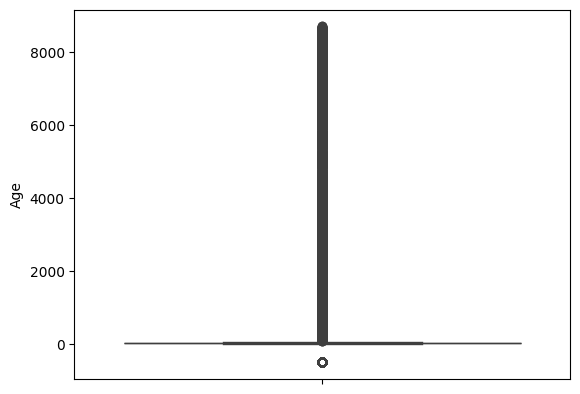

In [11]:
sns.boxplot(data_raw['Age'])

Видим множество выбросов. Постараемся их поправить. \
Будем использовать метод, основанный на межквартильном расстоянии. \ 
То есть, будем считать подозрительными значениям все те значения, что находятся за пределами отрезка $$[Q_1 - 1.5 * (Q_3 - Q_1), Q_3 + 1.5 * (Q_3 - Q_1)]$$ 

In [12]:
def IQRBasedMethod(data_frame: pd.Series, feature: str, eps: float, is_Int: bool, allow_Negative: bool):
    result = data_frame

    quartiles = result[feature].quantile([0.25, 0.5, 0.75]).tolist()
    feature_median = quartiles[1]
    IQR = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - 1.5 * IQR
    if (not allow_Negative) and (lower_bound < 0):
        lower_bound = result[result[feature] >= 0][feature].min()
    upper_bound = quartiles[2] + 1.5 * IQR

    

    for i in range(0, result[feature].size):
        if not (result.at[i, feature] < lower_bound or
            result.at[i, feature] > upper_bound or
            result.at[i, feature] == NAN_INDICATING_CONSTANT):
            continue
        
        resulting_value = result.at[i, feature]

        client_subset = result[result['Customer_ID'] == result.at[i, 'Customer_ID']]
        client_subset = client_subset[client_subset[feature] != NAN_INDICATING_CONSTANT]
        if (not allow_Negative):
            client_subset = client_subset[client_subset[feature] >= 0]
        
        if (not client_subset[feature].size):
            resulting_value = feature_median
        else:
            client_mode = stats.mode(client_subset[feature])[0]

            if (np.isnan(client_mode)):
                resulting_value = client_subset[feature].median()
            elif (result.at[i, feature] < client_mode - eps - (client_mode - eps) * ((not allow_Negative) and client_mode - eps < 0) or
                result.at[i, feature] > client_mode + eps):
                resulting_value = client_mode
        

        if (is_Int):
            resulting_value = int(resulting_value)

        result.at[i, feature] = resulting_value

    return result[feature]

<Axes: ylabel='Age'>

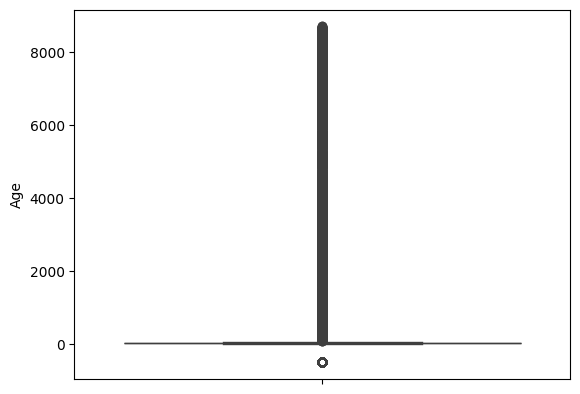

In [13]:
sns.boxplot(data_raw['Age'])

In [14]:
data_raw['Age'] = IQRBasedMethod(data_frame = data_raw, feature = 'Age', eps = 1, is_Int = True, allow_Negative = False)

In [15]:
print_info(data_raw, 'Age')

Вид признака: int32
Количество пропущенных значений: 0
Уникальные значения: [23 28 34 54 55 21 31 33 30 24 44 45 40 41 32 35 36 39 37 20 46 26 42 19
 48 38 43 22 16 18 15 27 25 14 17 47 53 56 29 49 51 50 52]


<Axes: ylabel='Age'>

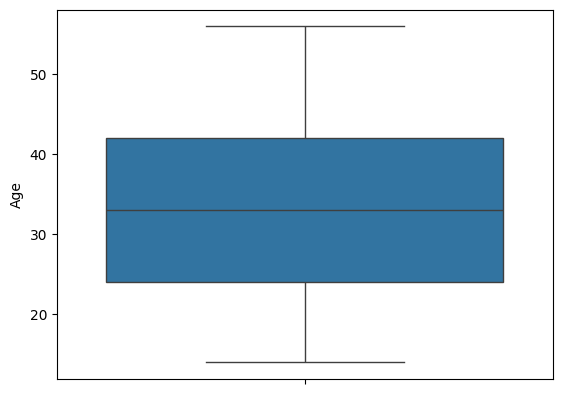

In [16]:
sns.boxplot(data_raw['Age'])

## MONTH - Месяц

In [17]:
print_info(data_raw, 'Month')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August']


In [18]:
def month_number(month: str):
    months = {'January' : 1, 'February' : 2, 'March' : 3, 'April' : 4,
               'May' : 5, 'June' : 6, 'July' : 7, 'August' : 8}
    return months[month]

# Преобразуем признак 'Month' в целочисленный
for i in range(0, data_raw['Month'].size):
    data_raw.at[i, 'Month'] = month_number(data_raw.at[i, 'Month'])

data_raw['Month'] = data_raw['Month'].astype(int)

In [19]:
print_info(data_raw, 'Month')

Вид признака: int32
Количество пропущенных значений: 0
Уникальные значения: [1 2 3 4 5 6 7 8]


In [20]:
## CREDIT_HISTORY_AGE - возраст кредитной истории

In [21]:
print_info(data_raw, 'Credit_History_Age')

Вид признака: object
Количество пропущенных значений: 9030
Уникальные значения: ['22 Years and 1 Months' nan '22 Years and 3 Months'
 '22 Years and 4 Months' '22 Years and 5 Months' '22 Years and 6 Months'
 '22 Years and 7 Months' '26 Years and 7 Months' '26 Years and 8 Months'
 '26 Years and 9 Months' '26 Years and 10 Months' '26 Years and 11 Months'
 '27 Years and 0 Months' '27 Years and 1 Months' '27 Years and 2 Months'
 '17 Years and 9 Months' '17 Years and 10 Months' '17 Years and 11 Months'
 '18 Years and 1 Months' '18 Years and 2 Months' '18 Years and 3 Months'
 '18 Years and 4 Months' '17 Years and 3 Months' '17 Years and 4 Months'
 '17 Years and 5 Months' '17 Years and 6 Months' '17 Years and 7 Months'
 '17 Years and 8 Months' '30 Years and 8 Months' '30 Years and 9 Months'
 '30 Years and 10 Months' '30 Years and 11 Months' '31 Years and 0 Months'
 '31 Years and 1 Months' '31 Years and 2 Months' '31 Years and 3 Months'
 '32 Years and 0 Months' '32 Years and 2 Months' '32 Years

In [22]:
data_raw['Credit_History_Age'] = data_raw['Credit_History_Age'].fillna(NAN_INDICATING_CONSTANT)

In [23]:
for i in range(0, data_raw['Credit_History_Age'].size):
    try:
        years_months = re.findall(r'\d+', str(data_raw.at[i, 'Credit_History_Age']))
        if (len(years_months) == 2):
            total_credit_history_months = int(years_months[0]) * 12 + int(years_months[1])
            data_raw.at[i, 'Credit_History_Age'] = total_credit_history_months
        else:
            raise ValueError
    except ValueError:
        data_raw.at[i, 'Credit_History_Age'] = NAN_INDICATING_CONSTANT

data_raw['Credit_History_Age'] = data_raw['Credit_History_Age'].astype(int)

In [24]:
allowed_history_subset = data_raw[data_raw['Credit_History_Age'] >= 0]
credit_history_median = int(np.median(allowed_history_subset['Credit_History_Age']))
credit_history_median

219

In [25]:
def findMostProbablePeriod(nums):
    result = []
    max_len = 0
    for i in range(0, len(nums) - 1):
        temp = []
        for j in range(i + 1, len(nums) - 1):
            if (nums[j] - nums[i] == j - i) and (j - i > max_len):
                temp.append([nums[j], j])
                max_len = j - i
        if (len(temp) > len(result)):
            result = temp
    
    result = result[len(result) - 1]
    return result

for i in range(0, data_raw['Credit_History_Age'].size):
    if (data_raw.at[i, 'Credit_History_Age'] == NAN_INDICATING_CONSTANT):
        client_subset = data_raw[data_raw['Customer_ID'] == data_raw.at[i, 'Customer_ID']]
        corrupted_credit_history_month = data_raw.at[i, 'Month']

        most_probable = findMostProbablePeriod(client_subset['Credit_History_Age'].tolist())
        if (most_probable) and (most_probable[1] > 0):
            data_raw.at[i, 'Credit_History_Age'] = most_probable[0] - (most_probable[1] - (corrupted_credit_history_month - 1))
        elif (client_subset[client_subset['Credit_History_Age'] >= 0].size() > 0):
            data_raw.at[i, 'Credit_History_Age'] = int(client_subset[client_subset['Credit_History_Age'] >= 0].median())
        else:
            data_raw.at[i, 'Credit_History_Age'] = credit_history_median

<Axes: ylabel='Credit_History_Age'>

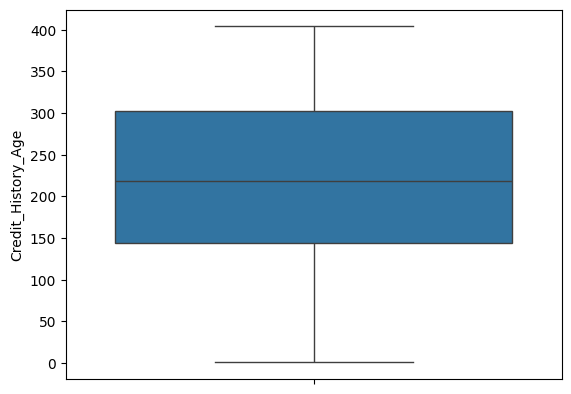

In [26]:
sns.boxplot(data_raw['Credit_History_Age'])

## ANNUAL INCOME - годовой доход

In [27]:
print_info(data_raw, 'Annual_Income')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['19114.12' '34847.84' '34847.84_' ... '20002.88' '39628.99' '39628.99_']


In [28]:
data_raw['Annual_Income'] = toNumeric(data_raw, feature = 'Annual_Income', isInt = False)
data_raw['Annual_Income'] = data_raw['Annual_Income'].astype(float)

In [29]:
print_info(data_raw, 'Annual_Income')

Вид признака: float64
Количество пропущенных значений: 0
Уникальные значения: [ 19114.12  34847.84 143162.64 ...  37188.1   20002.88  39628.99]


<Axes: ylabel='Annual_Income'>

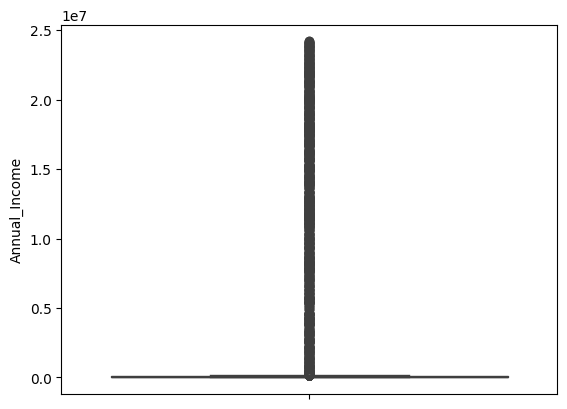

In [30]:
sns.boxplot(data_raw['Annual_Income'])

In [31]:
data_raw['Annual_Income'] = IQRBasedMethod(data_raw, feature = 'Annual_Income', eps = 2000, is_Int = False, allow_Negative = False)

In [32]:
print_info(data_raw, 'Annual_Income')

Вид признака: float64
Количество пропущенных значений: 0
Уникальные значения: [ 19114.12  34847.84 143162.64 ...  37188.1   20002.88  39628.99]


<Axes: ylabel='Annual_Income'>

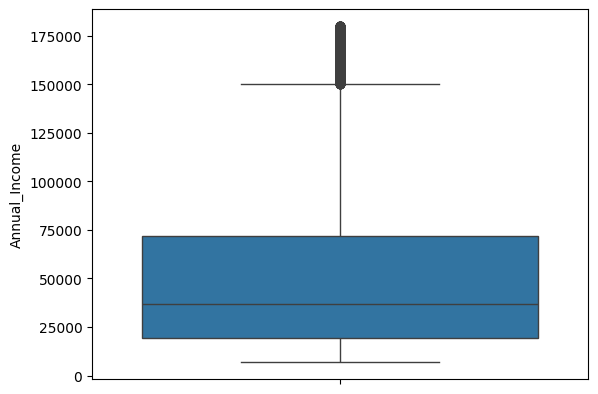

In [33]:
sns.boxplot(data_raw['Annual_Income'])

## MONTHLY_INHAND_SALARY - месячная зарплата

In [34]:
print_info(data_raw, 'Monthly_Inhand_Salary')

Вид признака: float64
Количество пропущенных значений: 15002
Уникальные значения: [1824.84333333           nan 3037.98666667 ... 3097.00833333 1929.90666667
 3359.41583333]


In [35]:
data_raw['Monthly_Inhand_Salary'] = data_raw['Monthly_Inhand_Salary'].fillna(NAN_INDICATING_CONSTANT)

<Axes: ylabel='Monthly_Inhand_Salary'>

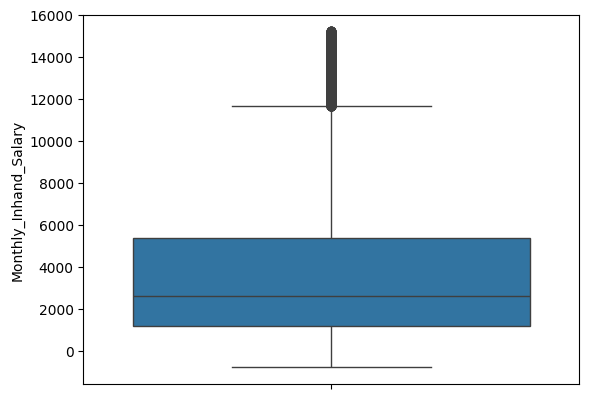

In [36]:
sns.boxplot(data_raw['Monthly_Inhand_Salary'])

In [37]:
data_raw['Monthly_Inhand_Salary'] = IQRBasedMethod(data_raw, feature = 'Monthly_Inhand_Salary', eps = 500.0, is_Int = False, allow_Negative = True)

In [38]:
print_info(data_raw, 'Monthly_Inhand_Salary')

Вид признака: float64
Количество пропущенных значений: 0
Уникальные значения: [ 1824.84333333  3037.98666667 12187.22       ...  3097.00833333
  1929.90666667  3359.41583333]


<Axes: ylabel='Monthly_Inhand_Salary'>

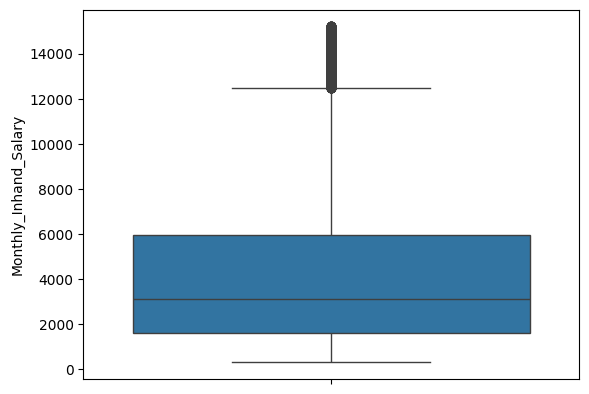

In [39]:
sns.boxplot(data_raw['Monthly_Inhand_Salary'])

## NUM_BANK_ACCOUNTS - количество банковских счетов

In [40]:
print_info(data_raw, 'Num_Bank_Accounts')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [   3    2    1    7    4    0    8    5    6    9   10 1414 1231   67
  572 1488   91  528 1647 1696 1338  649  889 1668  685  857  975 1496
 1534 1620   37 1388 1429 1332 1588  120 1777 1096  803  494  744 1139
  831 1613  741  121  665 1748 1644  823 1356 1651   87  711  450  210
 1671 1722  648  672 1662 1495  510  666  429 1131 1434  980 1026  526
  718 1300 1312 1315  501 1566  480 1042  322  628 1016  333 1265  791
  427  563  905 1190 1036 1611   38  619  555 1769  280  752 1201  812
 1487  222  212 1019 1222  610 1714 1308  525 1158 1115 1616  754 1601
  797 1577  521  703  933  959  809 1089 1656 1113 1715  964 1533 1789
  871  434 1295  565 1724  603  677  541  698 1101  464 1539 1462 1011
 1257 1727   45  244 1266  897  535  484  331  675  826  946 1675  105
 1327  845  549  473  710  527  908   68 1628  371  445 1168  868  687
  455 1003   26 1526  618  598  351 1342 1783  683 1557 1335  416 1747
 

<Axes: ylabel='Num_Bank_Accounts'>

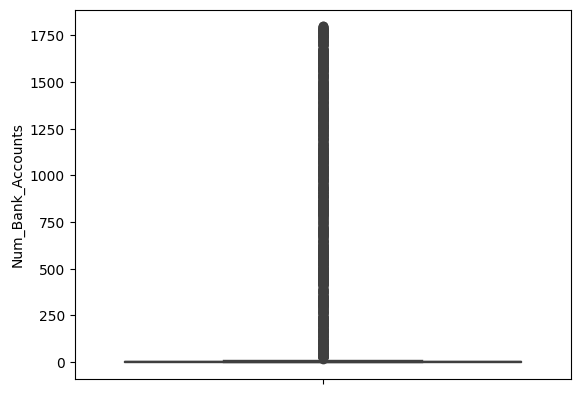

In [41]:
sns.boxplot(data_raw['Num_Bank_Accounts'])

In [42]:
data_raw['Num_Bank_Accounts'] = IQRBasedMethod(data_raw, feature = 'Num_Bank_Accounts', eps = 1, is_Int = True, allow_Negative = False)

<Axes: ylabel='Num_Bank_Accounts'>

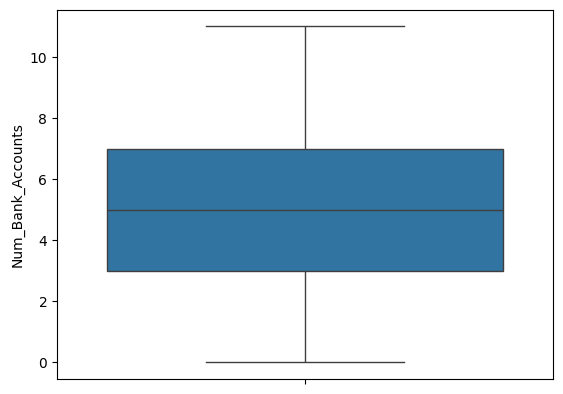

In [43]:
sns.boxplot(data_raw['Num_Bank_Accounts'])

## NUM_CREDIT_CARD - количество кредитных карт

In [44]:
print_info(data_raw, 'Num_Credit_Card')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [   4 1385    5 ...  955 1430  679]


<Axes: ylabel='Num_Credit_Card'>

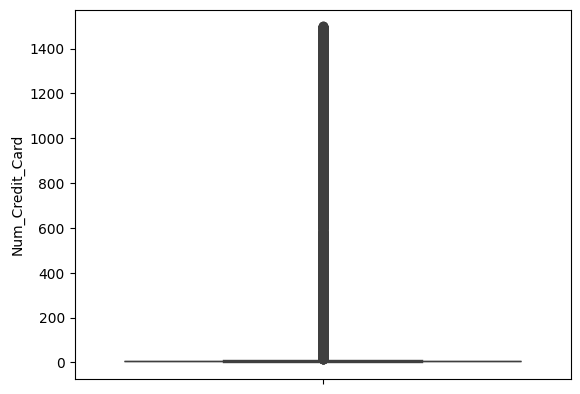

In [45]:
sns.boxplot(data_raw['Num_Credit_Card'])

In [46]:
data_raw['Num_Credit_Card'] = IQRBasedMethod(data_raw, feature = 'Num_Credit_Card', eps = 1, is_Int = True, allow_Negative = True)

<Axes: ylabel='Num_Credit_Card'>

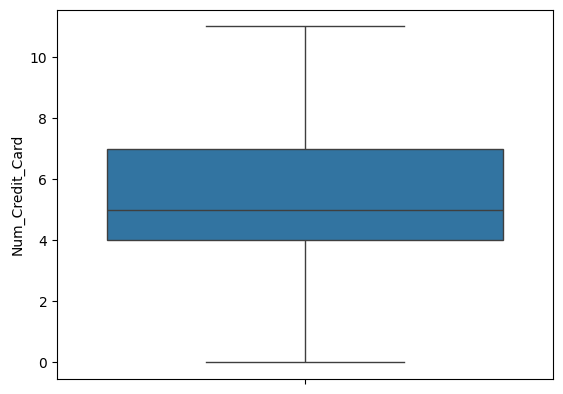

In [47]:
sns.boxplot(data_raw['Num_Credit_Card'])

In [48]:
print_info(data_raw, 'Num_Credit_Card')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [ 4  5  1  7  6  8  3  9  2 10 11  0]


## INTEREST_RATE - процент по кредиту

In [49]:
print_info(data_raw, 'Interest_Rate')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [   3    6    8 ... 1347  387 5729]


<Axes: ylabel='Interest_Rate'>

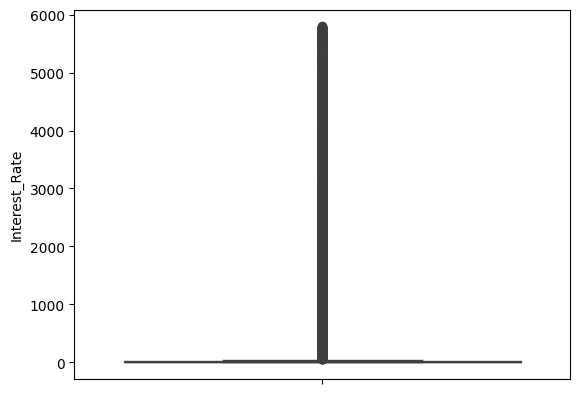

In [50]:
sns.boxplot(data_raw['Interest_Rate'])

In [51]:
data_raw['Interest_Rate'] = IQRBasedMethod(data_raw, feature = 'Interest_Rate', eps = 5, is_Int = True, allow_Negative = False)

<Axes: ylabel='Interest_Rate'>

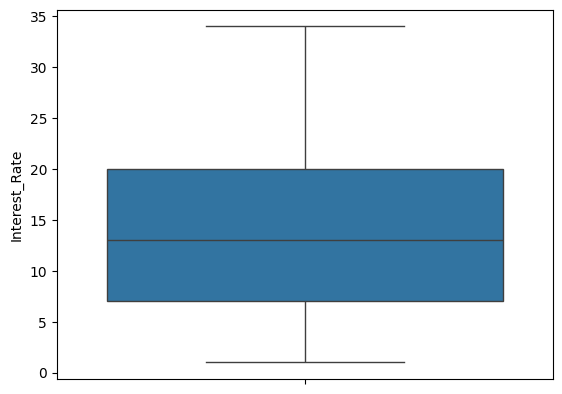

In [52]:
sns.boxplot(data_raw['Interest_Rate'])

In [53]:
print_info(data_raw, 'Interest_Rate')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [ 3  6  8  4  5 15  7 12 20  1 14 32 16 17 10 31 25 18 19  9 24 13 33 11
 21 29 28 30 23 34  2 27 26 22]


## NUM_OF_LOAN - количество кредитов

In [54]:
print_info(data_raw, 'Num_of_Loan')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['4' '1' '3' '967' '-100' '0' '0_' '2' '3_' '2_' '7' '5' '5_' '6' '8' '8_'
 '9' '9_' '4_' '7_' '1_' '1464' '6_' '622' '352' '472' '1017' '945' '146'
 '563' '341' '444' '720' '1485' '49' '737' '1106' '466' '728' '313' '843'
 '597_' '617' '119' '663' '640' '92_' '1019' '501' '1302' '39' '716' '848'
 '931' '1214' '186' '424' '1001' '1110' '1152' '457' '1433' '1187' '52'
 '1480' '1047' '1035' '1347_' '33' '193' '699' '329' '1451' '484' '132'
 '649' '995' '545' '684' '1135' '1094' '1204' '654' '58' '348' '614'
 '1363' '323' '1406' '1348' '430' '153' '1461' '905' '1312' '1424' '1154'
 '95' '1353' '1228' '819' '1006' '795' '359' '1209' '590' '696' '1185_'
 '1465' '911' '1181' '70' '816' '1369' '143' '1416' '455' '55' '1096'
 '1474' '420' '1131' '904' '89' '1259' '527' '1241' '449' '983' '418'
 '319' '23' '238' '638' '138' '235_' '280' '1070' '1484' '274' '494'
 '1459_' '404' '1354' '1495' '1391' '601' '1313' '1319' '

In [55]:
data_raw['Num_of_Loan'] = toNumeric(data_raw, feature = 'Num_of_Loan', isInt = True)
data_raw['Num_of_Loan'] = data_raw['Num_of_Loan'].astype(int)

<Axes: ylabel='Num_of_Loan'>

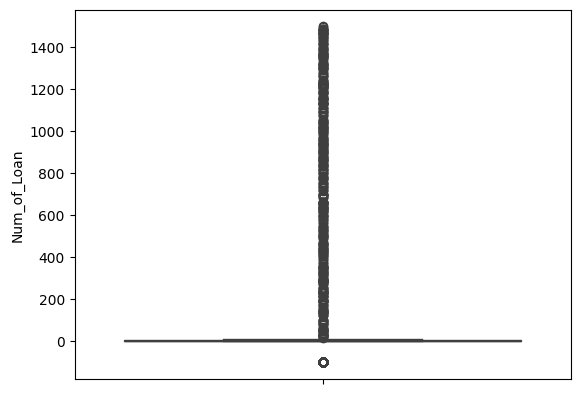

In [56]:
sns.boxplot(data_raw['Num_of_Loan'])

In [57]:
data_raw['Num_of_Loan'] = IQRBasedMethod(data_raw, feature = 'Num_of_Loan', eps = 1, is_Int = True, allow_Negative = False)

<Axes: ylabel='Num_of_Loan'>

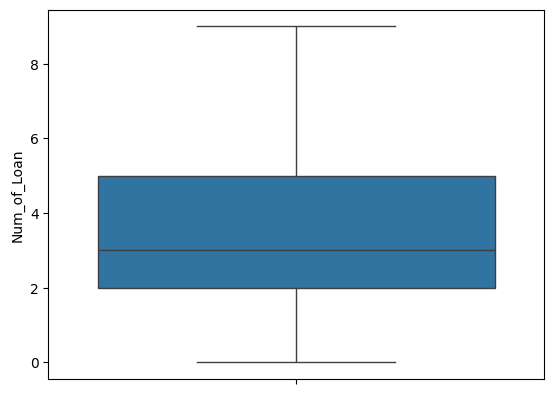

In [58]:
sns.boxplot(data_raw['Num_of_Loan'])

In [59]:
print_info(data_raw, 'Num_of_Loan')

Вид признака: int32
Количество пропущенных значений: 0
Уникальные значения: [4 1 3 0 2 7 5 6 8 9]


## DELAY_FROM_DUE_DATE - количество просроченных дней со дня оплаты

In [60]:
print_info(data_raw, 'Delay_from_due_date')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [ 3 -1  5  6  8  7 13 10  0  4  9  1 12 11 30 31 34 27 14  2 -2 16 17 15
 23 22 21 18 19 52 51 48 53 26 43 28 25 20 47 46 49 24 61 29 50 58 45 59
 55 56 57 54 62 65 64 67 36 41 33 32 39 44 42 60 35 38 -3 63 40 37 -5 -4
 66]


<Axes: ylabel='Delay_from_due_date'>

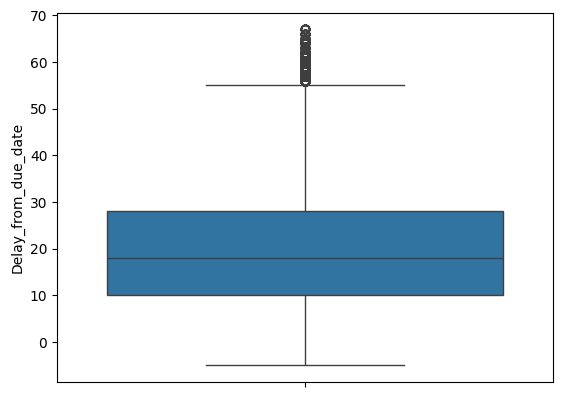

In [61]:
sns.boxplot(data_raw['Delay_from_due_date'])

In [62]:
data_raw['Delay_from_due_date'] = IQRBasedMethod(data_raw, feature = 'Delay_from_due_date', eps = 5, is_Int = True, allow_Negative = False)

<Axes: ylabel='Delay_from_due_date'>

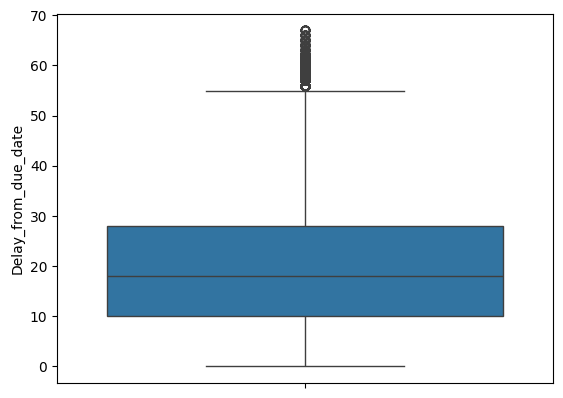

In [63]:
sns.boxplot(data_raw['Delay_from_due_date'])

## NUM_OF_DELAYED_PAYMENT - количество просроченных платежей

In [64]:
print_info(data_raw, 'Num_of_Delayed_Payment')

Вид признака: object
Количество пропущенных значений: 7002
Уникальные значения: ['7' nan '4' '8_' '6' '1' '-1' '3_' '0' '8' '5' '3' '9' '12' '15' '17'
 '10' '2' '2_' '11' '14' '20' '22' '13' '13_' '14_' '16' '12_' '18' '19'
 '23' '24' '21' '3318' '3083' '22_' '1338' '4_' '26' '11_' '3104' '21_'
 '25' '10_' '183_' '9_' '1106' '834' '19_' '24_' '17_' '23_' '2672' '20_'
 '2008' '-3' '538' '6_' '1_' '16_' '27' '-2' '3478' '2420' '15_' '707'
 '708' '26_' '18_' '3815' '28' '5_' '1867' '2250' '1463' '25_' '7_' '4126'
 '2882' '1941' '2655' '2628' '132' '3069' '306' '0_' '3539' '3684' '1823'
 '4128' '1946' '827' '2297' '2566' '904' '182' '929' '3568' '2503' '1552'
 '2812' '1697' '3764' '851' '3905' '923' '88' '1668' '3253' '808' '2689'
 '3858' '642' '3457' '1402' '1732' '3154' '847' '3037' '2204' '3103'
 '1063' '2056' '1282' '1841' '2569_' '211' '793' '3484' '411' '3491'
 '2072' '3050' '1049' '2162' '3402' '2753' '27_' '1718' '1014' '3260'
 '3855' '84' '2311' '3251' '1832' '4069' '3010' '733' '

In [65]:
data_raw['Num_of_Delayed_Payment'] = data_raw['Num_of_Delayed_Payment'].fillna(NAN_INDICATING_CONSTANT)
data_raw['Num_of_Delayed_Payment'] = toNumeric(data_raw, 'Num_of_Delayed_Payment', isInt = True)
data_raw['Num_of_Delayed_Payment'] = data_raw['Num_of_Delayed_Payment'].astype(int)

<Axes: ylabel='Num_of_Delayed_Payment'>

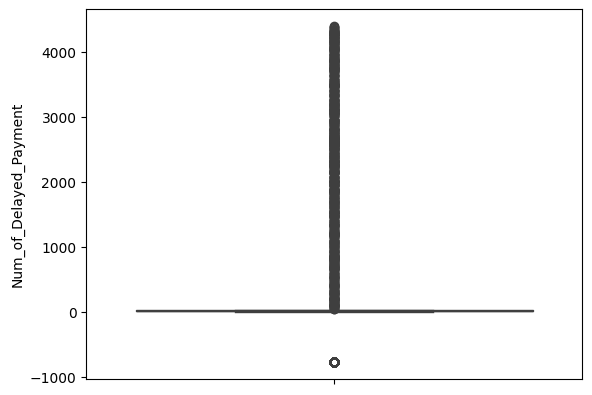

In [66]:
sns.boxplot(data_raw['Num_of_Delayed_Payment'])

In [67]:
data_raw['Num_of_Delayed_Payment'] = IQRBasedMethod(data_raw, feature = 'Num_of_Delayed_Payment', eps = 1, is_Int = True, allow_Negative = False)

<Axes: ylabel='Num_of_Delayed_Payment'>

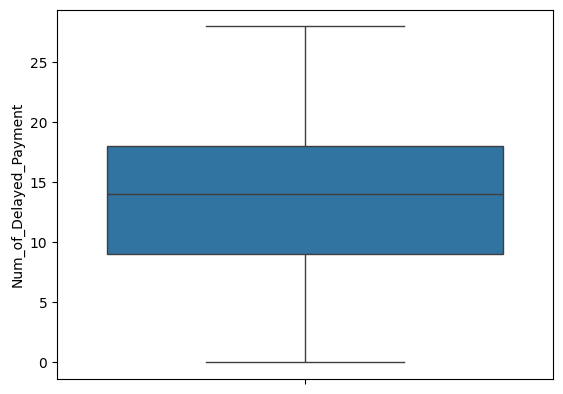

In [68]:
sns.boxplot(data_raw['Num_of_Delayed_Payment'])

## CHANGED_CREDIT_LIMIT - изменение кредитного лимита

In [69]:
print_info(data_raw, 'Changed_Credit_Limit')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['11.27' '_' '6.27' ... '17.509999999999998' '25.16' '21.17']


In [70]:
data_raw['Changed_Credit_Limit'] = toNumeric(data_raw, feature = 'Changed_Credit_Limit', isInt = False)
data_raw['Changed_Credit_Limit'] = data_raw['Changed_Credit_Limit'].astype(float)

<Axes: ylabel='Changed_Credit_Limit'>

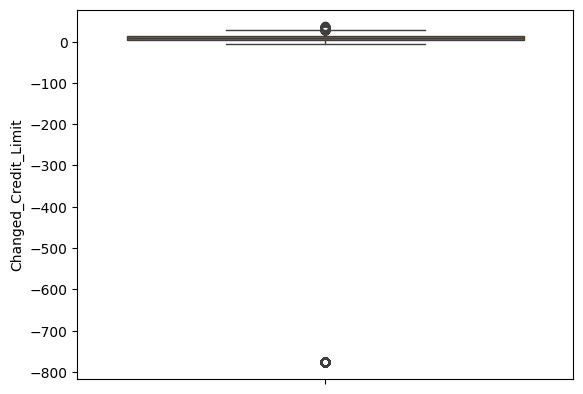

In [71]:
sns.boxplot(data_raw['Changed_Credit_Limit'])

In [72]:
data_raw['Changed_Credit_Limit'] = IQRBasedMethod(data_raw, feature = 'Changed_Credit_Limit', eps = 5, is_Int = False, allow_Negative = True)

<Axes: ylabel='Changed_Credit_Limit'>

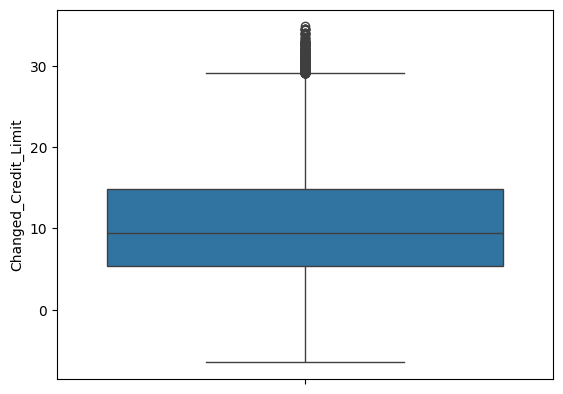

In [73]:
sns.boxplot(data_raw['Changed_Credit_Limit'])

## NUM_CREDIT_INQUIRIES - количество запросов кредита (количество запросов клиента о кредите)

In [74]:
print_info(data_raw, 'Num_Credit_Inquiries')

Вид признака: float64
Количество пропущенных значений: 1965
Уникальные значения: [   4.    2.    3. ... 1361.  310.   74.]


In [75]:
data_raw['Num_Credit_Inquiries'] = data_raw['Num_Credit_Inquiries'].fillna(NAN_INDICATING_CONSTANT)
data_raw['Num_Credit_Inquiries'] = data_raw['Num_Credit_Inquiries'].astype(int)

<Axes: ylabel='Num_Credit_Inquiries'>

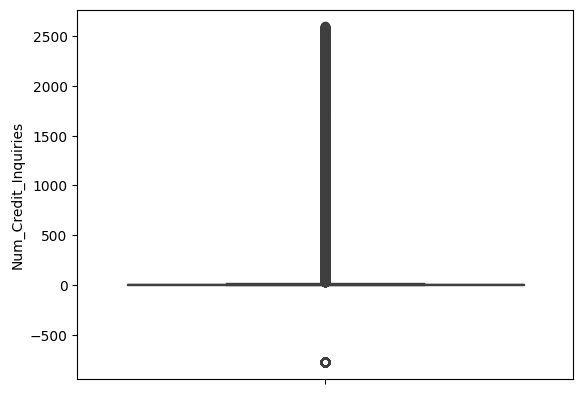

In [76]:
sns.boxplot(data_raw['Num_Credit_Inquiries'])

In [77]:
data_raw['Num_Credit_Inquiries'] = IQRBasedMethod(data_raw, feature = 'Num_Credit_Inquiries', eps = 2, is_Int = True, allow_Negative = False)

<Axes: ylabel='Num_Credit_Inquiries'>

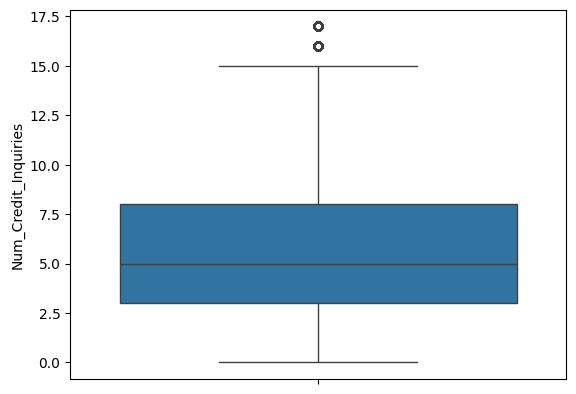

In [78]:
sns.boxplot(data_raw['Num_Credit_Inquiries'])

## CREDIT_MIX - разнообразие кредитов

In [79]:
print_info(data_raw, 'Credit_Mix')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['_' 'Good' 'Standard' 'Bad']


In [80]:
data_raw['Credit_Mix'].value_counts()

Credit_Mix
Standard    36479
Good        24337
_           20195
Bad         18989
Name: count, dtype: int64

In [81]:
for i in range(0, data_raw['Credit_Mix'].size):
    if data_raw.at[i, 'Credit_Mix'] == 'Good':
        data_raw.at[i, 'Credit_Mix'] = 2
    elif data_raw.at[i, 'Credit_Mix'] == 'Standard':
        data_raw.at[i, 'Credit_Mix'] = 1
    elif data_raw.at[i, 'Credit_Mix'] == 'Bad':
        data_raw.at[i, 'Credit_Mix'] = 0
    else:
        data_raw.at[i, 'Credit_Mix'] = NAN_INDICATING_CONSTANT

data_raw['Credit_Mix'] = data_raw['Credit_Mix'].astype(int)
data_raw['Credit_Mix'].value_counts()

Credit_Mix
 1      36479
 2      24337
-777    20195
 0      18989
Name: count, dtype: int64

In [82]:
data_raw['Credit_Mix'] = IQRBasedMethod(data_raw, feature = 'Credit_Mix', eps = 1, is_Int = True, allow_Negative = False)

In [83]:
data_raw['Credit_Mix'].value_counts()

Credit_Mix
1    45848
2    30384
0    23768
Name: count, dtype: int64

## OUTSTANDING_DEBT - долг по кредиту

In [84]:
print_info(data_raw, 'Outstanding_Debt')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['809.98' '605.03' '1303.01' ... '3571.7_' '3571.7' '502.38']


In [85]:
data_raw['Outstanding_Debt'] = toNumeric(data_raw, feature = 'Outstanding_Debt', isInt = False)
data_raw['Outstanding_Debt'] = data_raw['Outstanding_Debt'].astype(float)

<Axes: ylabel='Outstanding_Debt'>

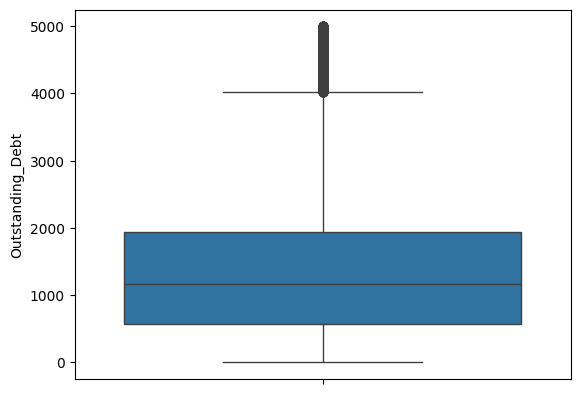

In [86]:
sns.boxplot(data_raw['Outstanding_Debt'])

In [87]:
data_raw['Outstanding_Debt'] = IQRBasedMethod(data_raw, feature = 'Outstanding_Debt', eps = 200, is_Int = False, allow_Negative = False)

<Axes: ylabel='Outstanding_Debt'>

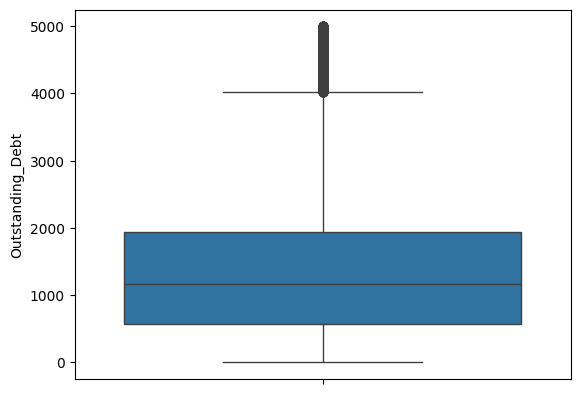

In [88]:
sns.boxplot(data_raw['Outstanding_Debt'])

## CREDIT_UTILIZATION_RATIO - доля используемого кредитного лимита

In [89]:
print_info(data_raw, 'Credit_Utilization_Ratio')

Вид признака: float64
Количество пропущенных значений: 0
Уникальные значения: [26.82261962 31.94496006 28.60935202 ... 41.25552226 33.63820798
 34.19246265]


<Axes: ylabel='Credit_Utilization_Ratio'>

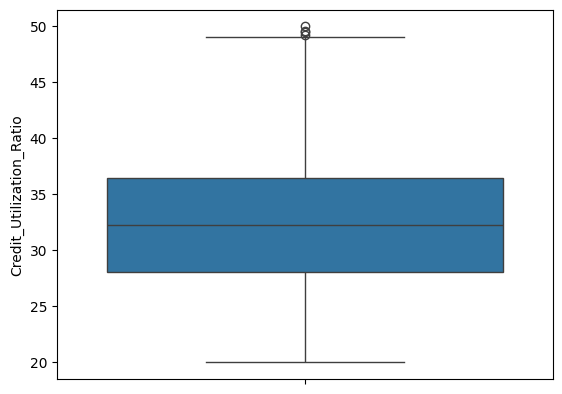

In [90]:
sns.boxplot(data_raw['Credit_Utilization_Ratio'])

In [91]:
data_raw['Credit_Utilization_Ratio'] = IQRBasedMethod(data_raw, feature = 'Credit_Utilization_Ratio', eps = 5, is_Int = False, allow_Negative = False)

<Axes: ylabel='Credit_Utilization_Ratio'>

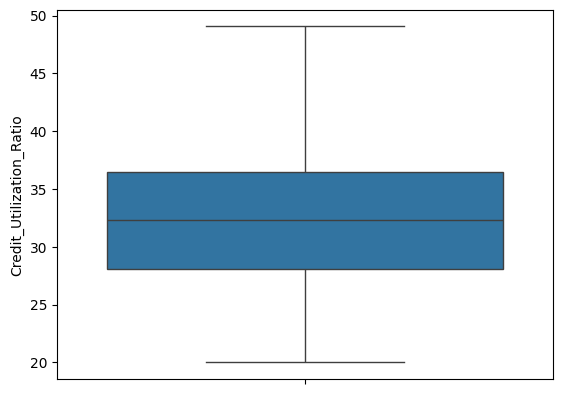

In [92]:
sns.boxplot(data_raw['Credit_Utilization_Ratio'])

## PAYMENT_OF_MIN_AMOUNT - оплачен ли минимальный взнос

In [93]:
print_info(data_raw, 'Payment_of_Min_Amount')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['No' 'NM' 'Yes']


Будем считать, что NM - это No

In [94]:
for i in range(0, data_raw['Payment_of_Min_Amount'].size):
    if data_raw.at[i, 'Payment_of_Min_Amount'] == 'Yes':
        data_raw.at[i, 'Payment_of_Min_Amount'] = 1
    else:
        data_raw.at[i, 'Payment_of_Min_Amount'] = 0

data_raw['Payment_of_Min_Amount'] = data_raw['Payment_of_Min_Amount'].astype(int)

In [95]:
data_raw['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
1    52326
0    47674
Name: count, dtype: int64

## TOTAL_EMI_PER_MONTH - Суммарное количество плат по кредитам

In [96]:
print_info(data_raw, 'Total_EMI_per_month')

Вид признака: float64
Количество пропущенных значений: 0
Уникальные значения: [4.95749492e+01 1.88162146e+01 2.46992319e+02 ... 1.21120000e+04
 3.51040226e+01 5.86380000e+04]


<Axes: ylabel='Total_EMI_per_month'>

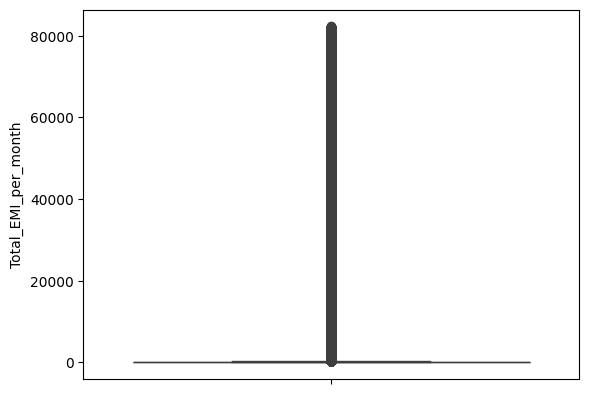

In [97]:
sns.boxplot(data_raw['Total_EMI_per_month'])

In [98]:
data_raw['Total_EMI_per_month'] = IQRBasedMethod(data_raw, feature = 'Total_EMI_per_month', eps = 200, is_Int = False, allow_Negative = False)

<Axes: ylabel='Total_EMI_per_month'>

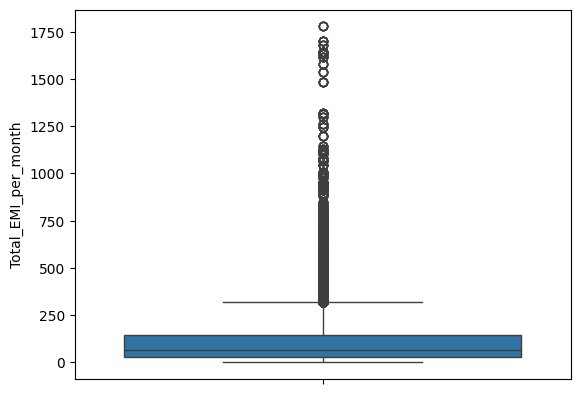

In [99]:
sns.boxplot(data_raw['Total_EMI_per_month'])

## AMOUNT_INVESTED_MONTHLY - Количество денег на вкладе

In [100]:
print_info(data_raw, 'Amount_invested_monthly')

Вид признака: object
Количество пропущенных значений: 4479
Уникальные значения: ['80.41529543900253' '118.28022162236736' '81.699521264648' ...
 '24.02847744864441' '251.67258219721603' '167.1638651610451']


In [101]:
data_raw['Amount_invested_monthly'].value_counts()

Amount_invested_monthly
__10000__             4305
0.0                    169
80.41529543900253        1
36.66235139442514        1
89.7384893604547         1
                      ... 
36.541908593249026       1
93.45116318631192        1
140.80972223052834       1
38.73937670100975        1
167.1638651610451        1
Name: count, Length: 91049, dtype: int64

In [102]:
for i in range(0, data_raw['Amount_invested_monthly'].size):
    if data_raw.at[i, 'Amount_invested_monthly'] == '__10000__':
        data_raw.at[i, 'Amount_invested_monthly'] = NAN_INDICATING_CONSTANT

data_raw['Amount_invested_monthly'] = data_raw['Amount_invested_monthly'].astype(float)

In [103]:
print_info(data_raw, 'Amount_invested_monthly')

Вид признака: float64
Количество пропущенных значений: 8784
Уникальные значения: [ 80.41529544 118.28022162  81.69952126 ...  24.02847745 251.6725822
 167.16386516]


In [104]:
data_raw['Amount_invested_monthly'] = data_raw['Amount_invested_monthly'].fillna(NAN_INDICATING_CONSTANT)

<Axes: ylabel='Amount_invested_monthly'>

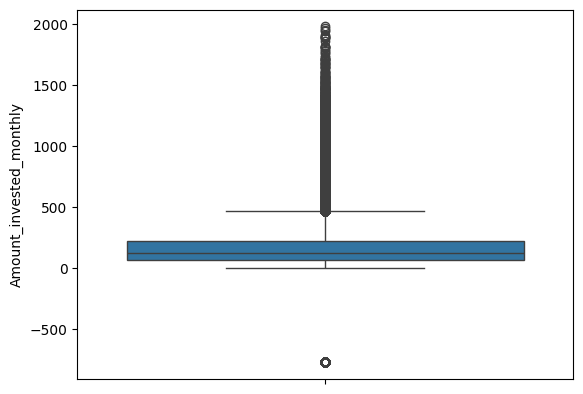

In [105]:
sns.boxplot(data_raw['Amount_invested_monthly'])

In [106]:
data_raw['Amount_invested_monthly'] = IQRBasedMethod(data_raw, feature = 'Amount_invested_monthly', eps = 100, is_Int = False, allow_Negative = False)

<Axes: ylabel='Amount_invested_monthly'>

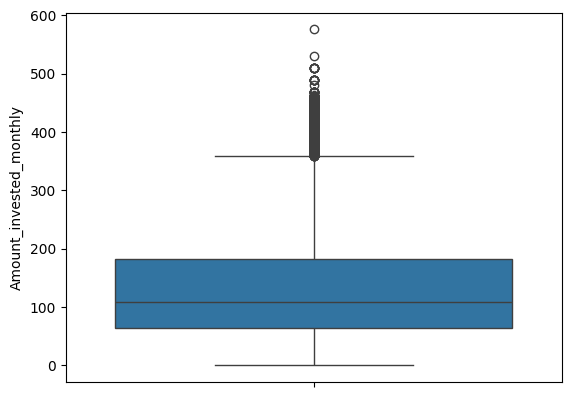

In [107]:
sns.boxplot(data_raw['Amount_invested_monthly'])

## MONTHLY_BALANCE - месячный баланс по карте

In [108]:
print_info(data_raw, 'Monthly_Balance')

Вид признака: object
Количество пропущенных значений: 1200
Уникальные значения: ['312.49408867943663' '284.62916249607184' '331.2098628537912' ...
 516.8090832742814 319.1649785257098 393.6736955618808]


In [109]:
data_raw['Monthly_Balance'] = data_raw['Monthly_Balance'].fillna(NAN_INDICATING_CONSTANT)
data_raw['Monthly_Balance'] = toNumeric(data_raw, feature = 'Monthly_Balance', isInt = False)
data_raw['Monthly_Balance'] = data_raw['Monthly_Balance'].astype(float)

<Axes: ylabel='Monthly_Balance'>

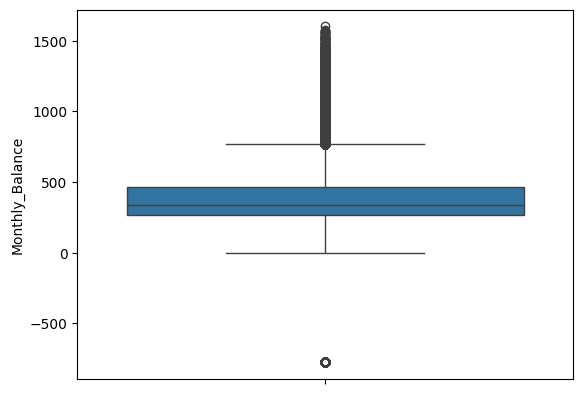

In [110]:
sns.boxplot(data_raw['Monthly_Balance'])

In [111]:
data_raw['Monthly_Balance'] = IQRBasedMethod(data_raw, feature = 'Monthly_Balance', eps = 0, is_Int = False, allow_Negative = False)

<Axes: ylabel='Monthly_Balance'>

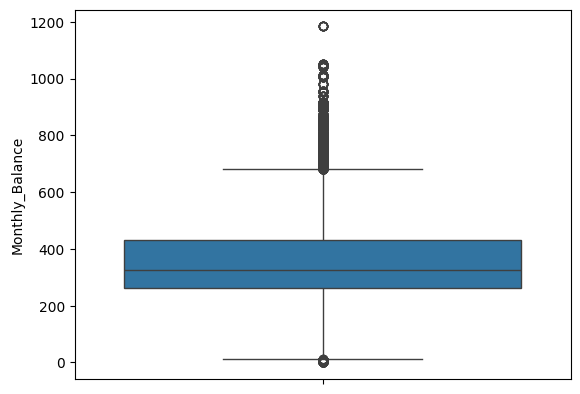

In [112]:
sns.boxplot(data_raw['Monthly_Balance'])

## PAYMENT_BEHAVIOUR - финансовое поведение

In [113]:
print_info(data_raw, 'Payment_Behaviour')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['High_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'High_spent_Medium_value_payments' '!@9#%8'
 'High_spent_Large_value_payments']


'!@9#%8' - Явно пропущенные значения, восстановим их с помощью моды по клиенту.

In [114]:
for i in range(0, data_raw['Payment_Behaviour'].size):
    if not (data_raw.at[i, 'Payment_Behaviour'] == '!@9#%8'):
        continue

    client_subset = data_raw[data_raw['Customer_ID'] == data_raw.at[i, 'Customer_ID']]
    client_subset = data_raw[data_raw['Payment_Behaviour'] != '!@9#%8']

    if (not client_subset['Payment_Behaviour'].size):
        data_raw.at[i, 'Payment_Behaviour'] = data_raw[data_raw['Payment_Behaviour'] != '!@9#%8']['Payment_Behaviour'].mode().iat[0]
    else:
        data_raw.at[i, 'Payment_Behaviour'] = client_subset['Payment_Behaviour'].mode().iat[0]


In [115]:
data_raw['Payment_Behaviour'].value_counts()

Payment_Behaviour
Low_spent_Small_value_payments      33113
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: count, dtype: int64

Теперь можно разделить этот признак на два: \
- бинарный признак Amount_Spent
- - 0 - low_spent
- - 1 - hight_spent
- признак Payment_Value
- - 0 - Small_value_payments
- - 1 - Medium_value_payments
- - 2 - Large_value_payments

In [116]:
data_raw.shape

(100000, 26)

In [117]:
data_raw['Amount_Spent'] = NAN_INDICATING_CONSTANT
data_raw['Payment_Value'] = NAN_INDICATING_CONSTANT
data_raw.shape

(100000, 28)

In [118]:
for i in range(0, data_raw['Payment_Behaviour'].size):
    match data_raw.at[i, 'Payment_Behaviour']:
        case 'Low_spent_Small_value_payments':
            data_raw.at[i, 'Amount_Spent'] = 0
            data_raw.at[i, 'Payment_Value'] = 0
        case 'High_spent_Medium_value_payments':
            data_raw.at[i, 'Amount_Spent'] = 1
            data_raw.at[i, 'Payment_Value'] = 1
        case 'Low_spent_Medium_value_payments':
            data_raw.at[i, 'Amount_Spent'] = 0
            data_raw.at[i, 'Payment_Value'] = 1
        case 'High_spent_Large_value_payments':
            data_raw.at[i, 'Amount_Spent'] = 1
            data_raw.at[i, 'Payment_Value'] = 2
        case 'High_spent_Small_value_payments':
            data_raw.at[i, 'Amount_Spent'] = 1
            data_raw.at[i, 'Payment_Value'] = 0
        case 'Low_spent_Large_value_payments':
            data_raw.at[i, 'Amount_Spent'] = 0
            data_raw.at[i, 'Payment_Value'] = 2
        case _:
            data_raw.at[i, 'Amount_Spent'] = NAN_INDICATING_CONSTANT
            data_raw.at[i, 'Payment_Value'] = NAN_INDICATING_CONSTANT


In [119]:
print_info(data_raw, 'Amount_Spent')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [1 0]


In [120]:
print_info(data_raw, 'Payment_Value')

Вид признака: int64
Количество пропущенных значений: 0
Уникальные значения: [0 2 1]


Теперь можем удалить признак PAYMENT_BEHAVIOUR

In [121]:
data_raw = data_raw.drop('Payment_Behaviour', axis = 1)
data_raw.shape

(100000, 27)

## TYPE_OF_LOAN - Вид кредита

In [122]:
print_info(data_raw, 'Type_of_Loan')

Вид признака: object
Количество пропущенных значений: 11408
Уникальные значения: ['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan'
 'Credit-Builder Loan' 'Auto Loan, Auto Loan, and Not Specified' ...
 'Home Equity Loan, Auto Loan, Auto Loan, and Auto Loan'
 'Payday Loan, Student Loan, Mortgage Loan, and Not Specified'
 'Personal Loan, Auto Loan, Mortgage Loan, Student Loan, and Student Loan']


In [123]:
data_raw['Type_of_Loan'].unique().tolist()

['Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan',
 'Credit-Builder Loan',
 'Auto Loan, Auto Loan, and Not Specified',
 'Not Specified',
 nan,
 'Credit-Builder Loan, and Mortgage Loan',
 'Not Specified, Auto Loan, and Student Loan',
 'Personal Loan, Debt Consolidation Loan, and Auto Loan',
 'Not Specified, and Payday Loan',
 'Credit-Builder Loan, Personal Loan, and Auto Loan',
 'Payday Loan, and Payday Loan',
 'Not Specified, Student Loan, and Personal Loan',
 'Personal Loan, Payday Loan, Student Loan, Auto Loan, Home Equity Loan, Student Loan, and Payday Loan',
 'Not Specified, Student Loan, Student Loan, Credit-Builder Loan, and Auto Loan',
 'Payday Loan, and Home Equity Loan',
 'Credit-Builder Loan, Not Specified, Mortgage Loan, Payday Loan, Credit-Builder Loan, and Personal Loan',
 'Mortgage Loan, Debt Consolidation Loan, Payday Loan, Auto Loan, and Not Specified',
 'Credit-Builder Loan, Mortgage Loan, Mortgage Loan, Credit-Builder Loan, and Student Loan',
 'No

In [124]:
data_raw['Type_of_Loan'] = data_raw['Type_of_Loan'].fillna(STRING_NAN_INDICATING_CONSTANT)

Unique_Types_of_Loans = set()

for i in range(0, data_raw['Type_of_Loan'].size):
    if data_raw.at[i, 'Type_of_Loan'] == STRING_NAN_INDICATING_CONSTANT:
        continue

    loan_string = data_raw.at[i, 'Type_of_Loan']
    loan_string = loan_string.replace(' ', '')
    loan_array = loan_string.split(',')
    if (len(loan_array) > 1):
        loan_array[len(loan_array) - 1] = loan_array[len(loan_array) - 1][3:]
    loan_set = set(loan_array)
    Unique_Types_of_Loans.update(loan_set)
    data_raw.at[i, 'Type_of_Loan'] = loan_set

for each in Unique_Types_of_Loans:
    print(each)

AutoLoan
DebtConsolidationLoan
PaydayLoan
HomeEquityLoan
Credit-BuilderLoan
MortgageLoan
StudentLoan
NotSpecified
PersonalLoan


Создадим 9 бинарных признаков на каждый вид кредита (multi-hot encoding)

In [125]:
data_raw[data_raw['Type_of_Loan'] == STRING_NAN_INDICATING_CONSTANT]['Num_of_Loan'].value_counts()

Num_of_Loan
0    11408
Name: count, dtype: int64

Видим, что все пропущенные значения говорят нам о том, что у человека просто нет кредитов, что будет соответсвовать нулям во всех колонках вида кредита


In [126]:
data_raw['LoanType_HomeEquityLoan'] = 0
data_raw['LoanType_AutoLoan'] = 0
data_raw['LoanType_NotSpecified'] = 0
data_raw['LoanType_StudentLoan'] = 0
data_raw['LoanType_Credit-BuilderLoan'] = 0
data_raw['LoanType_MortgageLoan'] = 0
data_raw['LoanType_PersonalLoan'] = 0
data_raw['LoanType_PaydayLoan'] = 0
data_raw['LoanType_DebtConsolidationLoan'] = 0

In [127]:
data_raw.shape

(100000, 36)

In [128]:
data_raw.columns

Index(['ID', 'Customer_ID', 'Month', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score',
       'Amount_Spent', 'Payment_Value', 'LoanType_HomeEquityLoan',
       'LoanType_AutoLoan', 'LoanType_NotSpecified', 'LoanType_StudentLoan',
       'LoanType_Credit-BuilderLoan', 'LoanType_MortgageLoan',
       'LoanType_PersonalLoan', 'LoanType_PaydayLoan',
       'LoanType_DebtConsolidationLoan'],
      dtype='object')

Заполним теперь эти колонки, а затем удалим признак Type_of_Loan

In [129]:
for i in range(0, data_raw['Type_of_Loan'].size):
    if data_raw.at[i, 'Type_of_Loan'] == STRING_NAN_INDICATING_CONSTANT:
        continue

    for item in data_raw.at[i, 'Type_of_Loan']:
        data_raw.at[i, 'LoanType_' + item] = 1

In [130]:
data_raw['LoanType_HomeEquityLoan'] = data_raw['LoanType_HomeEquityLoan'].astype(bool)
data_raw['LoanType_AutoLoan'] = data_raw['LoanType_AutoLoan'].astype(bool)
data_raw['LoanType_NotSpecified'] = data_raw['LoanType_NotSpecified'].astype(bool)
data_raw['LoanType_StudentLoan'] = data_raw['LoanType_StudentLoan'].astype(bool)
data_raw['LoanType_Credit-BuilderLoan'] = data_raw['LoanType_Credit-BuilderLoan'].astype(bool)
data_raw['LoanType_MortgageLoan'] = data_raw['LoanType_MortgageLoan'].astype(bool)
data_raw['LoanType_PersonalLoan'] = data_raw['LoanType_PersonalLoan'].astype(bool)
data_raw['LoanType_PaydayLoan'] = data_raw['LoanType_PaydayLoan'].astype(bool)
data_raw['LoanType_DebtConsolidationLoan'] = data_raw['LoanType_DebtConsolidationLoan'].astype(bool)

In [131]:
print_info(data_raw, 'LoanType_HomeEquityLoan')
print_info(data_raw, 'LoanType_AutoLoan')
print_info(data_raw, 'LoanType_NotSpecified')
print_info(data_raw, 'LoanType_StudentLoan')
print_info(data_raw, 'LoanType_Credit-BuilderLoan')
print_info(data_raw, 'LoanType_MortgageLoan')
print_info(data_raw, 'LoanType_PersonalLoan')
print_info(data_raw, 'LoanType_PaydayLoan')
print_info(data_raw, 'LoanType_DebtConsolidationLoan')

Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [ True False]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [ True False]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [False  True]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [False  True]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [ True False]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [False  True]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [ True False]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [False  True]
Вид признака: bool
Количество пропущенных значений: 0
Уникальные значения: [False  True]


In [132]:
data_raw = data_raw.drop('Type_of_Loan', axis = 1)

In [133]:
data_raw.shape

(100000, 35)

## OCCUPATION - Профессия

In [134]:
print_info(data_raw, 'Occupation')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect']


In [135]:
data_raw['Occupation'].value_counts()

Occupation
_______          7062
Lawyer           6575
Architect        6355
Engineer         6350
Scientist        6299
Mechanic         6291
Accountant       6271
Developer        6235
Media_Manager    6232
Teacher          6215
Entrepreneur     6174
Doctor           6087
Journalist       6085
Manager          5973
Musician         5911
Writer           5885
Name: count, dtype: int64

In [136]:
for i in range(0, data_raw['Occupation'].size):
    if data_raw.at[i, 'Occupation'] != '_______':
        continue

    client_subset = data_raw[data_raw['Customer_ID'] == data_raw.at[i, 'Customer_ID']]
    client_subset = client_subset[client_subset['Occupation'] != '_______']
    client_subset = client_subset[client_subset['Occupation'] != STRING_NAN_INDICATING_CONSTANT]

    if (not client_subset['Occupation'].size):
        data_raw.at[i, 'Occupation'] = STRING_NAN_INDICATING_CONSTANT
    else:
        data_raw.at[i, 'Occupation'] = client_subset['Occupation'].mode().iat[0]

In [137]:
print_info(data_raw, 'Occupation')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


In [138]:
data_raw['Occupation'] = data_raw['Occupation'].astype('category')

In [139]:
data_raw.shape

(100000, 35)

In [140]:
data_raw = pd.get_dummies(data_raw, columns = ['Occupation'], prefix = ['Occupation'])
data_raw.shape

(100000, 49)

## CREDIT_SCORE - Кредитоспособность

In [141]:
print_info(data_raw, 'Credit_Score')

Вид признака: object
Количество пропущенных значений: 0
Уникальные значения: ['Good' 'Standard' 'Poor']


In [142]:
for i in range(0, data_raw['Credit_Score'].size):
    if data_raw.at[i, 'Credit_Score'] == 'Good':
        data_raw.at[i, 'Credit_Score'] = 2
    elif data_raw.at[i, 'Credit_Score'] == 'Standard':
        data_raw.at[i, 'Credit_Score'] = 1
    else:
        data_raw.at[i, 'Credit_Score'] = 0

data_raw['Credit_Score'] = data_raw['Credit_Score'].astype(int)

In [143]:
print_info(data_raw, 'Credit_Score')

Вид признака: int32
Количество пропущенных значений: 0
Уникальные значения: [2 1 0]


## Выбрасываем лишнее

In [144]:
data_raw = data_raw.drop(['Month', 'ID', 'Customer_ID'], axis = 1)
data_raw.shape

(100000, 46)

In [145]:
data_raw = data_raw.drop(data_raw[data_raw['Age'] * 12 + 11 - data_raw['Credit_History_Age'] < 0].index)
data_raw.reset_index(inplace=True)

In [146]:
data_raw.shape

(89735, 47)

In [147]:
data_raw.drop_duplicates(keep = 'first')

,index,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,0,23,19114.12,1824.843333,3,4,3,4,3,7,...,False,False,False,False,False,False,False,True,False,False
1,1,23,19114.12,1824.843333,3,4,3,4,3,4,...,False,False,False,False,False,False,False,True,False,False
2,2,23,19114.12,1824.843333,3,4,3,4,3,7,...,False,False,False,False,False,False,False,True,False,False
3,3,23,19114.12,1824.843333,3,4,3,4,5,4,...,False,False,False,False,False,False,False,True,False,False
4,4,23,19114.12,1824.843333,3,4,3,4,6,4,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89730,99987,28,20002.88,1929.906667,10,8,29,5,33,25,...,False,False,False,False,False,False,False,False,False,False
89731,99988,28,20002.88,1929.906667,10,8,29,5,33,25,...,False,False,False,False,False,False,False,False,False,False
89732,99989,28,20002.88,1929.906667,10,8,29,5,33,25,...,False,False,False,False,False,False,False,False,False,False
89733,99990,28,20002.88,1929.906667,10,8,29,5,33,26,...,False,False,False,False,False,False,False,False,False,False


In [148]:
data_raw.shape

(89735, 47)

In [149]:
data_raw = data_raw.drop('index', axis = 1)

In [150]:
data_raw.shape

(89735, 46)

# Визуализация данных

После обработки признаков можно перейти к визуализации данных. Взглянем на численные типы, исключая bool - категориальные

In [151]:
data_raw.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score',
       'Amount_Spent', 'Payment_Value', 'LoanType_HomeEquityLoan',
       'LoanType_AutoLoan', 'LoanType_NotSpecified', 'LoanType_StudentLoan',
       'LoanType_Credit-BuilderLoan', 'LoanType_MortgageLoan',
       'LoanType_PersonalLoan', 'LoanType_PaydayLoan',
       'LoanType_DebtConsolidationLoan', 'Occupation_Accountant',
       'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor',
       'Occupation_Engineer', 'Occupation_Entrepreneur',
       'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
   

In [152]:
columns_to_see = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 
                  'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
                  'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Credit_History_Age',
                  'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score']
data_raw[columns_to_see].describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
count,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000,89735.000000
mean,34.660790,49463.239833,4110.785373,5.491235,5.624405,15.035716,3.671065,21.818042,13.600490,10.609819,5.980933,1492.166526,32.244594,209.005115,105.022132,135.061934,350.870207,0.861637
std,10.462922,37747.427089,3141.717361,2.598429,2.083950,8.838736,2.479281,15.116791,6.258221,6.881826,3.894178,1188.448127,5.105481,96.323920,117.756295,97.611679,147.301767,0.674596
min,14.000000,7005.930000,303.645417,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-6.490000,0.000000,0.230000,20.000000,1.000000,0.000000,0.000000,0.007760,0.000000
25%,27.000000,19008.320000,1592.655000,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.475000,3.000000,590.080000,28.017148,134.000000,30.198050,62.740176,260.032178,0.000000
50%,35.000000,36535.570000,3043.955000,6.000000,6.000000,14.000000,3.000000,19.000000,14.000000,9.550000,6.000000,1221.110000,32.265294,209.000000,67.081622,107.534800,320.578692,1.000000
75%,43.000000,70137.400000,5843.924167,8.000000,7.000000,21.000000,6.000000,29.000000,18.000000,15.300000,9.000000,2097.730000,36.458881,280.000000,146.527303,179.912685,423.992549,1.000000
max,56.000000,179987.280000,15204.633333,11.000000,11.000000,34.000000,9.000000,67.000000,28.000000,34.850000,17.000000,4998.070000,49.064277,404.000000,1779.103254,576.184613,1183.930696,2.000000


In [153]:
correlation_matrix = data_raw[columns_to_see].corr()
correlation_matrix

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Credit_Score
Age,1.000000,0.137380,0.136571,-0.268225,-0.218113,-0.308946,-0.303542,-0.249685,-0.258609,-0.212032,-0.337852,-0.290340,0.038025,0.421021,-0.075487,0.060608,0.136585,0.225826
Annual_Income,0.137380,1.000000,0.998154,-0.285111,-0.223346,-0.305229,-0.265886,-0.250662,-0.286464,-0.177619,-0.289385,-0.276010,0.169302,0.277005,0.454714,0.428822,0.375601,0.217633
Monthly_Inhand_Salary,0.136571,0.998154,1.000000,-0.284025,-0.222558,-0.304231,-0.264346,-0.249815,-0.285274,-0.177425,-0.288739,-0.275521,0.169549,0.275633,0.443357,0.430494,0.377402,0.214898
Num_Bank_Accounts,-0.268225,-0.285111,-0.284025,1.000000,0.447381,0.585469,0.480377,0.559705,0.602211,0.329382,0.525785,0.514679,-0.069602,-0.488827,0.079659,-0.131027,-0.229231,-0.390453
Num_Credit_Card,-0.218113,-0.223346,-0.222558,0.447381,1.000000,0.500751,0.423767,0.482121,0.430272,0.255013,0.466719,0.495282,-0.055657,-0.414534,0.079280,-0.100772,-0.198628,-0.402087
Interest_Rate,-0.308946,-0.305229,-0.304231,0.585469,0.500751,1.000000,0.562840,0.587093,0.571921,0.364886,0.636510,0.631954,-0.074693,-0.570805,0.097641,-0.143759,-0.262182,-0.489440
Num_of_Loan,-0.303542,-0.265886,-0.264346,0.480377,0.423767,0.562840,1.000000,0.504283,0.483506,0.376621,0.573307,0.644907,-0.102607,-0.604112,0.382938,-0.126462,-0.388995,-0.361298
Delay_from_due_date,-0.249685,-0.250662,-0.249815,0.559705,0.482121,0.587093,0.504283,1.000000,0.541961,0.289714,0.542242,0.573180,-0.062779,-0.484713,0.105383,-0.116627,-0.231900,-0.430009
Num_of_Delayed_Payment,-0.258609,-0.286464,-0.285274,0.602211,0.430272,0.571921,0.483506,0.541961,1.000000,0.325293,0.505620,0.516695,-0.073330,-0.489557,0.078516,-0.122811,-0.227561,-0.374247
Changed_Credit_Limit,-0.212032,-0.177619,-0.177425,0.329382,0.255013,0.364886,0.376621,0.289714,0.325293,1.000000,0.375253,0.467244,-0.048240,-0.432338,0.084737,-0.087295,-0.163274,-0.161314


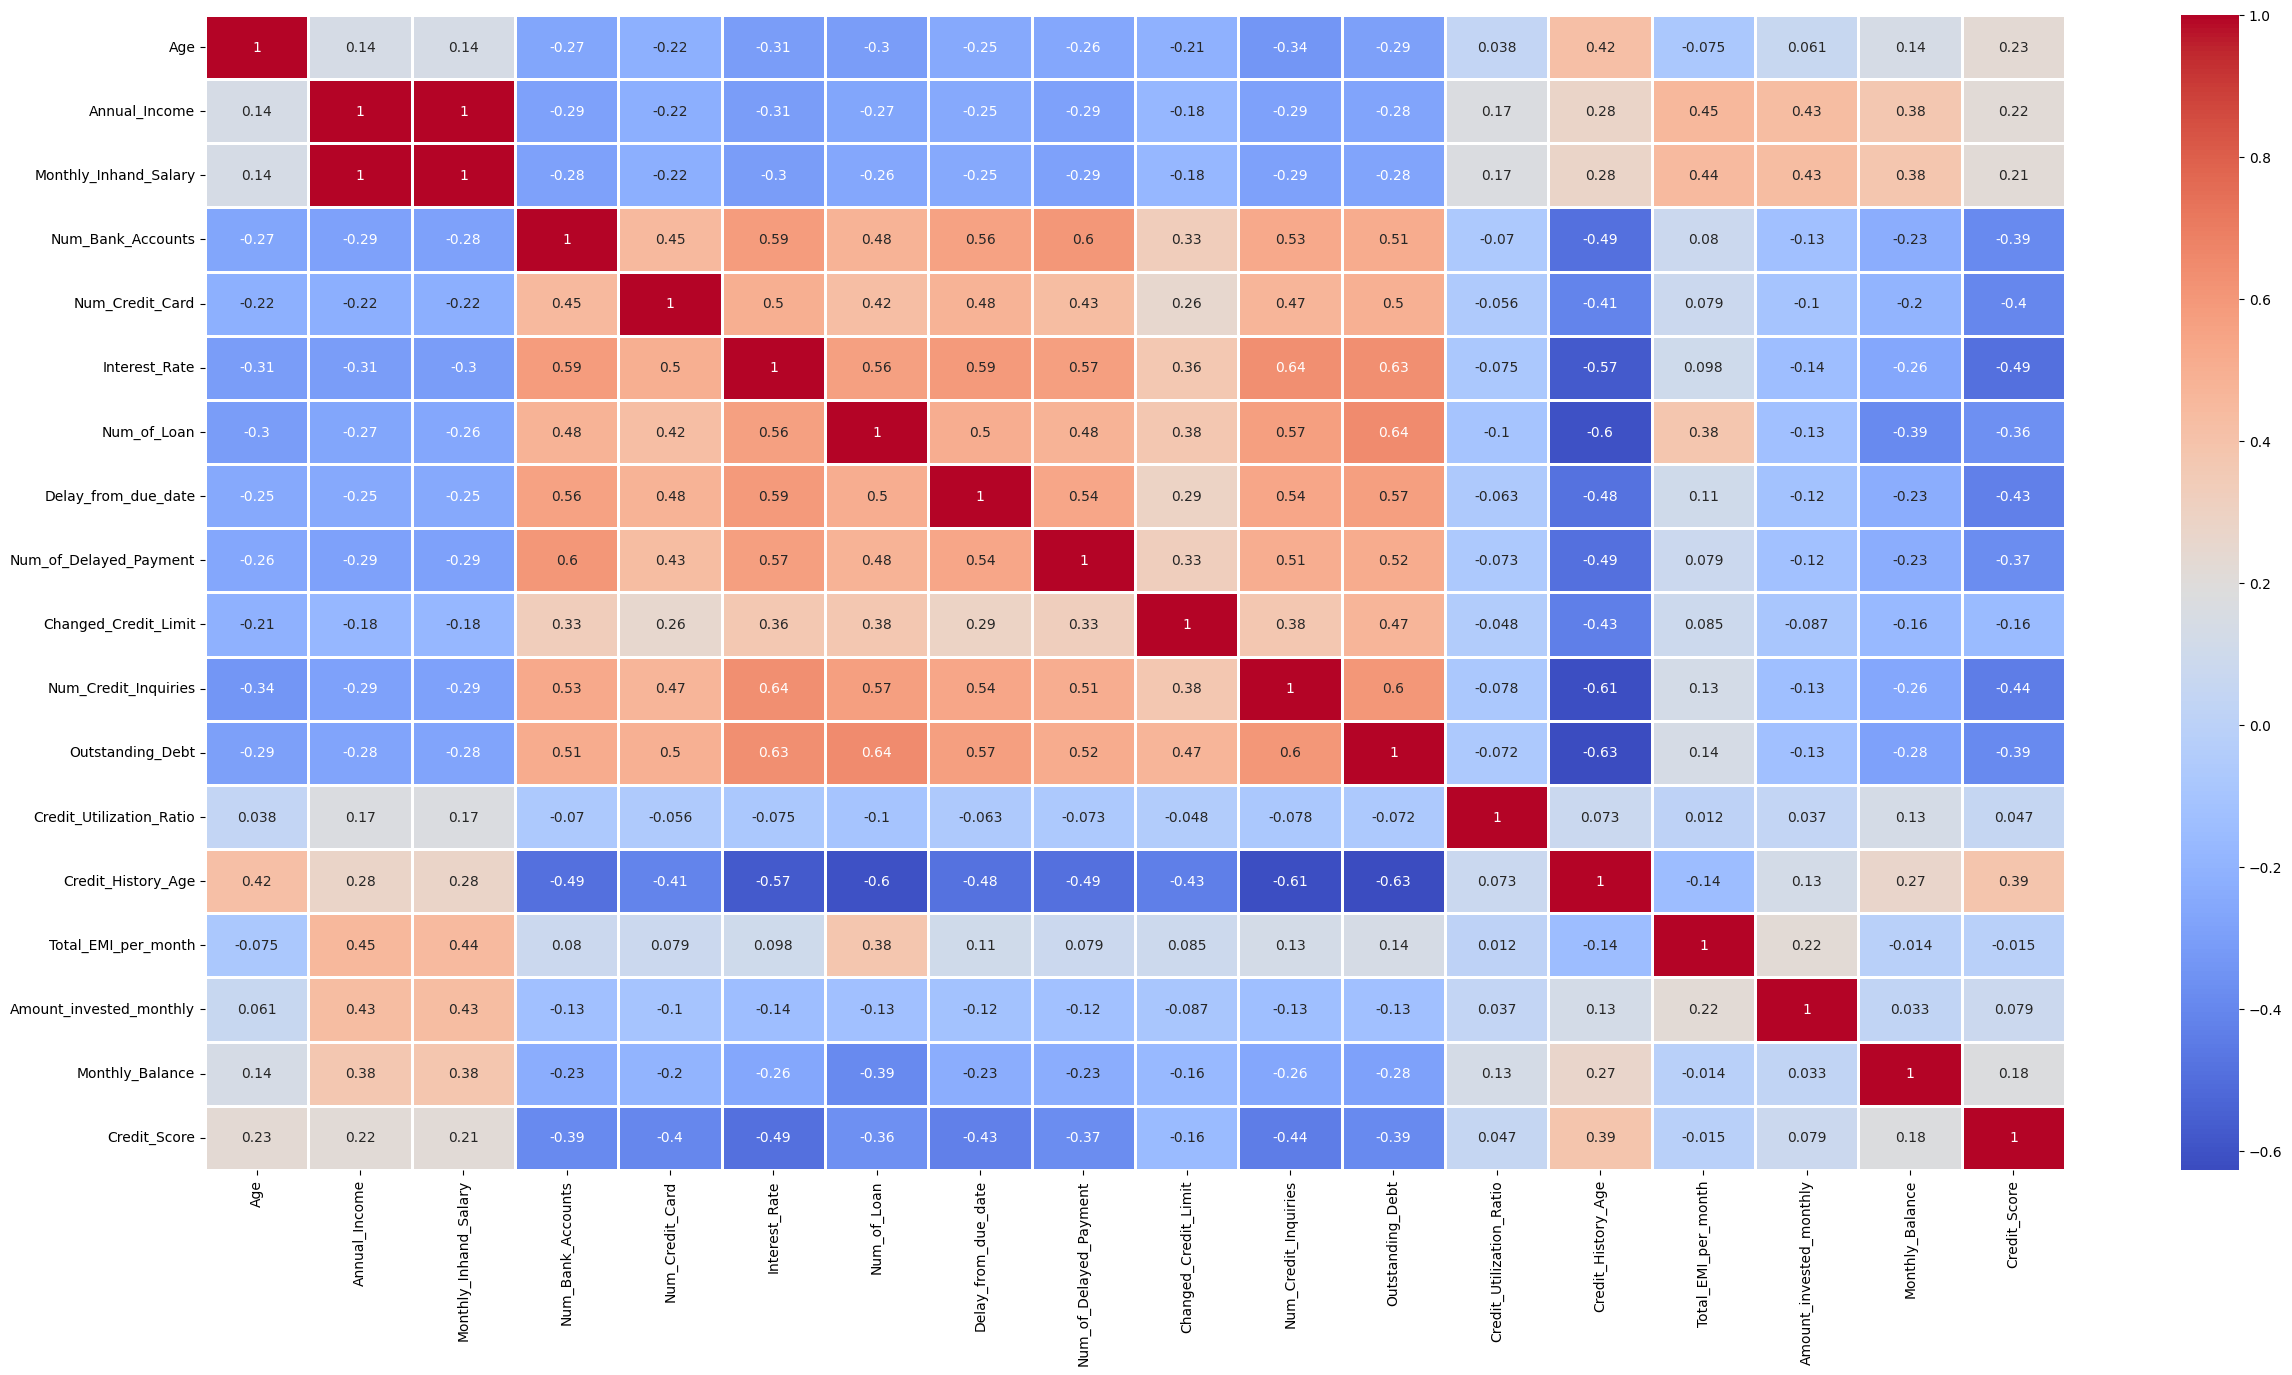

In [154]:
sns.heatmap(correlation_matrix, cmap = 'coolwarm', annot = True, linewidths = 1.0)
plt.gcf().set_size_inches(30,15)

Сразу видим, что корреляция между Annual_Income и Monthly_Inhand_Salary = 1, исключим тогда признак Annual_Income.

Также, видим, что чем длиннее кредитная история, тем меньше у человека долг по кредитам, меньше самих кредитов и количество запросов по кредитам, а также меньше процент по кредиту, что логично, так как чем больший период кредитной истории доступен для человека, тем более банк уверен в человеке. 

Видим, что на кредитную историю сильно влияет возраст кредитной истории, нынешний уровень процента по кредиту, просрочка по кредиту и количество просроченных платежей, а также долг по кредиту. 

In [155]:
data_raw = data_raw.drop('Annual_Income', axis = 1)

# Нормализация данных

Используем MinMax нормализацию, так как распределения у нас совсем не нормальные, чтобы использовать стандартизацию

In [156]:
data_raw.columns

Index(['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Monthly_Balance', 'Credit_Score',
       'Amount_Spent', 'Payment_Value', 'LoanType_HomeEquityLoan',
       'LoanType_AutoLoan', 'LoanType_NotSpecified', 'LoanType_StudentLoan',
       'LoanType_Credit-BuilderLoan', 'LoanType_MortgageLoan',
       'LoanType_PersonalLoan', 'LoanType_PaydayLoan',
       'LoanType_DebtConsolidationLoan', 'Occupation_Accountant',
       'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor',
       'Occupation_Engineer', 'Occupation_Entrepreneur',
       'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
       'Occupation_M

In [157]:
new_data = data_raw
scaler = preprocessing.MinMaxScaler()
columns_to_scale = ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
                    'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
                    'Credit_Utilization_Ratio', 'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance', 'Payment_Value']
new_data[columns_to_scale] = scaler.fit_transform(new_data[columns_to_scale])

In [158]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89735 entries, 0 to 89734
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             89735 non-null  float64
 1   Monthly_Inhand_Salary           89735 non-null  float64
 2   Num_Bank_Accounts               89735 non-null  float64
 3   Num_Credit_Card                 89735 non-null  float64
 4   Interest_Rate                   89735 non-null  float64
 5   Num_of_Loan                     89735 non-null  float64
 6   Delay_from_due_date             89735 non-null  float64
 7   Num_of_Delayed_Payment          89735 non-null  float64
 8   Changed_Credit_Limit            89735 non-null  float64
 9   Num_Credit_Inquiries            89735 non-null  float64
 10  Credit_Mix                      89735 non-null  float64
 11  Outstanding_Debt                89735 non-null  float64
 12  Credit_Utilization_Ratio        

# Разбивка данных

In [159]:
X = new_data.drop('Credit_Score', axis = 1)
y = new_data['Credit_Score']

In [160]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)
X_train.shape, X_test.shape

((67301, 44), (22434, 44))

# Обучение

## kNN

In [161]:
num_neighbors = list(range(1, 36))
train_mistake = list()
test_mistake = list() 
for k in range (1, 36):
    model = KNeighborsClassifier(n_neighbors = k, p = 1)
    model.fit(X_train, y_train)
    y_train_prediction = model.predict(X_train)
    y_test_prediction = model.predict(X_test)
    train_mistake.append(np.mean(y_train != y_train_prediction))
    test_mistake.append(np.mean(y_test != y_test_prediction))

Ошбика на трэйне в зависимости от k

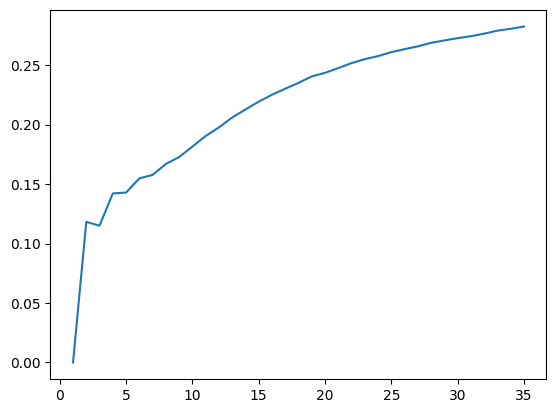

In [162]:
plt.plot(num_neighbors, train_mistake)

Ошибка на тесте в зависимости от k:

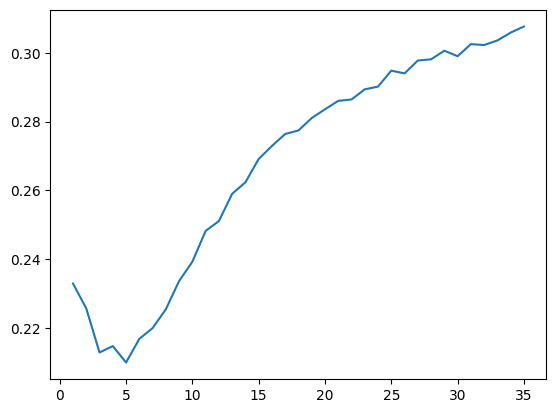

In [163]:
plt.plot(num_neighbors, test_mistake)

## RandomForest

In [164]:
rf_param = {"n_estimators": [15, 20, 25, 30, 35], 
            "max_depth": [5, 10, 15, 20, 25], 
            "min_samples_leaf": [1, 2, 3, 4, 5]} 
rf = RandomForestClassifier()             
grid = GridSearchCV(rf, param_grid = rf_param, cv = 5) 
grid.fit(X_train, y_train)
best_rf_err = 1 - grid.best_score_ 
best_rf_param = grid.best_params_ 
print("Error: {:.2f}%, parameters: {} ".format(100 * best_rf_err, best_rf_param))

Error: 20.07%, parameters: {'max_depth': 25, 'min_samples_leaf': 1, 'n_estimators': 35} 
